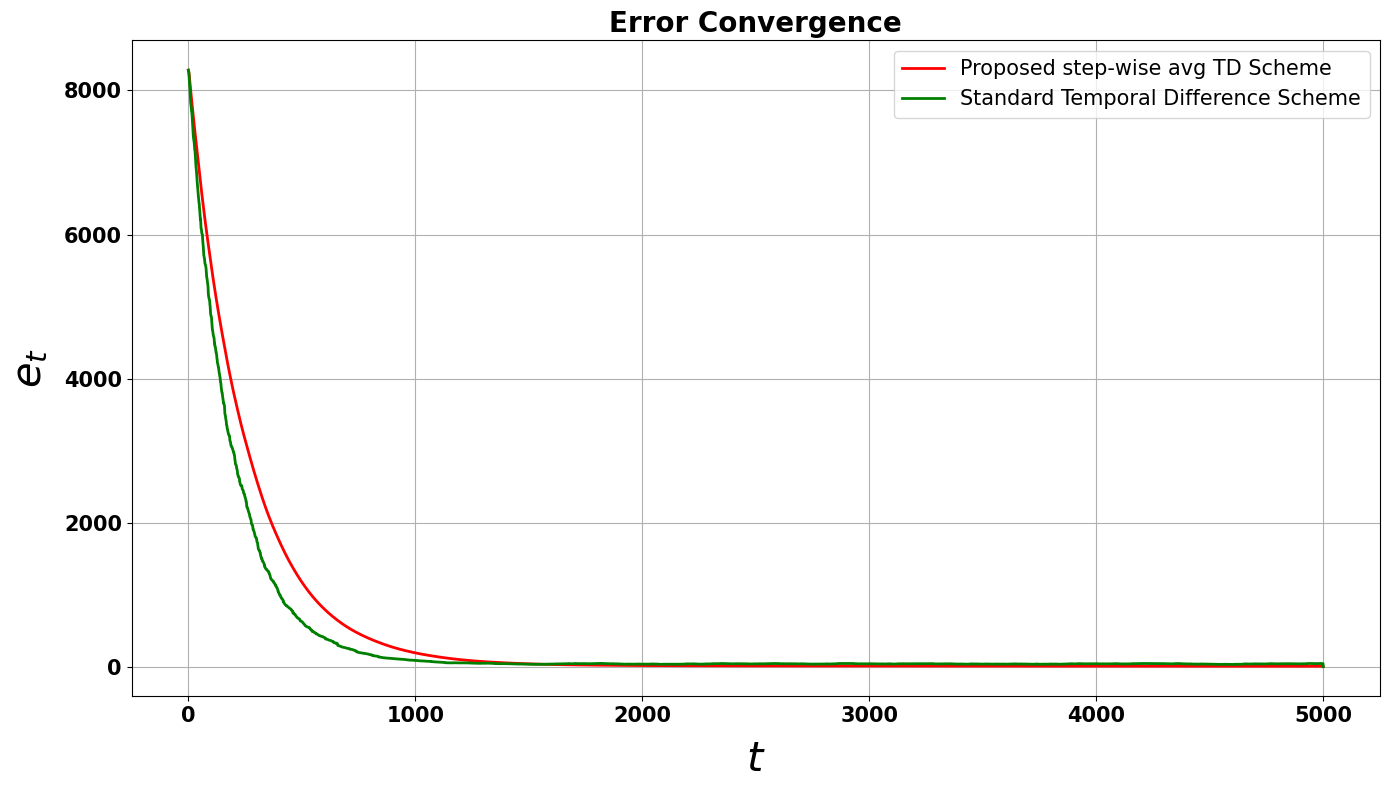

In [5]:
import numpy as np

def markov_gen(S, gamma, r):
    # Generate a Markov transition matrix P
    P = np.random.rand(S, S)
    P = P / P.sum(axis=1, keepdims=True)  # Normalize rows to make it stochastic

    # Find the eigenvalue that is close to 1
    storeeig, W = np.linalg.eig(P)
    ind = np.argmin(np.abs(storeeig - 1))  # Find index of the eigenvalue closest to 1

    # Extracting the stationary distribution
    p = np.real(W[:, ind])
    p = p * np.sign(p)  # Ensure p has consistent sign
    p = p / np.sum(p)  # Normalize to make it a probability distribution

    # Creating diagonal matrix of stationary distribution
    D = np.diag(p)

    # Reward vector
    R = 50 * np.random.rand(S, 1)

    # Generating the feature matrix
    phi = np.zeros((S, r))
    for i in range(r):
        phi[i, i] = 1

    # Projection matrix
    Proj = phi @ np.linalg.inv(phi.T @ D @ phi) @ phi.T @ D  # Projection matrix with pseudo-inverse

    # Corrected matrix A for calculating the fixed point of TD
    A = (phi.T @ (np.eye(S) - gamma * P) @ phi)
    b = phi.T @ R
    theta_t = np.linalg.solve(A, b).flatten()  # Fixed point of TD

    return theta_t, P, R, p, phi

# Parameters
S = 100  # Number of states
gamma = 0.5  # Discount factor
r = 10  # Rank of feature matrix
theta_st, P, R, p, phi = markov_gen(S, gamma, r)
T = 5000  # Number of iterations
g_store_1 = np.zeros((r,))
g_store_2 = np.zeros((r, r))
Ep = 50  # Number of epochs over which we average
alpha = 0.3  # Step size

# Averaging errors over epochs
avg_err = np.zeros(T)
avg_err_1 = np.zeros(T)

for k in range(Ep):
    x = np.zeros((r, T))
    y = np.zeros((r, T))
    err = np.zeros(T)
    err_1 = np.zeros(T)
    err[0] = np.linalg.norm(theta_st) ** 2
    err_1[0] = np.linalg.norm(theta_st) ** 2
    
    for i in range(T - 1):
        # Generate current state s_t from stationary distribution
        s_old = np.searchsorted(np.cumsum(p), np.random.rand())
        
        # Generating the next state s_t+1
        d = P[s_old, :]  # Distribution of s_t+1 | s_t
        s_new = np.searchsorted(np.cumsum(d), np.random.rand())  # New state s_t+1
        
        # Current reward with noise
        rew = R[s_old] + np.random.randn()
        
        # Scheme 1
        g_1 = rew * phi[s_old, :].reshape(-1, 1)
        g_store_1 = ((i) * g_store_1 + g_1.flatten()) / (i + 1)
        g_2 = np.outer(phi[s_old, :], (gamma * phi[s_new, :] - phi[s_old, :]))
        g_store_2 = ((i) * g_store_2 + g_2) / (i + 1)
        g = (rew + gamma * phi[s_new, :].dot(y[:, i]) - phi[s_old, :].dot(y[:, i])) * phi[s_old, :].reshape(-1, 1)
        
        # Update rules
        x[:, i + 1] = x[:, i] + alpha * (g_store_1 + g_store_2.dot(x[:, i]))
        y[:, i + 1] = y[:, i] + alpha * g.flatten()
        
        # Error calculations
        err[i] = np.linalg.norm(theta_st - x[:, i]) ** 2
        err_1[i] = np.linalg.norm(theta_st - y[:, i]) ** 2

    avg_err += err
    avg_err_1 += err_1

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(avg_err / Ep, 'r', linewidth=2, label='Proposed step-wise avg TD Scheme')
plt.plot(avg_err_1 / Ep, 'g', linewidth=2, label='Standard Temporal Difference Scheme')
plt.xlabel(r'${t}$', fontsize=30, fontweight='bold', labelpad=10)
plt.ylabel(r'$e_t$', fontsize=30, fontweight='bold', labelpad=10)
plt.title('Error Convergence', fontsize=20, fontweight='bold')
plt.grid(True)
plt.legend(fontsize=15)
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()
